This notebook will detail how I build and train a convolutional neural network that classifies a snippet of audio by the type of bat calls and number of bats echolocating in it. 

In [1]:
import keras
from keras import layers
from keras import models
from keras.utils import to_categorical

import numpy as np 
import matplotlib.pyplot as plt
plt.rcParams['agg.path.chunksize'] = 10000

Using TensorFlow backend.


In [2]:
training_specgms = np.load('training_data/training_specgram_257x194.npy')
training_labels = np.load('training_data/training_labels_257x194.npy')

testing_specgms = np.load('training_data/testing_specgram_257x194.npy')
test_labels = np.load('training_data/testing_labels_257x194.npy')

In [3]:
train_specgms = training_specgms.reshape(training_specgms.shape[0],training_specgms.shape[1],training_specgms.shape[2],1)
test_specgms = testing_specgms.reshape(testing_specgms.shape[0],testing_specgms.shape[1],testing_specgms.shape[2],1)

In [4]:
convert_snippet_type_to_categorical = {'none000' : 0,
                                       'none001' : 1,
                                       'single010':2,
                                       'single011':3,
                                       'single100':4,
                                       'single101':5,
                                       'multi010':6,
                                       'multi011':7,
                                       'multi110':8,
                                       'multi111':9 }

In [5]:
training_numlabels = map(lambda X : convert_snippet_type_to_categorical[X], training_labels)
testing_numlabels = map(lambda X : convert_snippet_type_to_categorical[X], test_labels)

In [6]:
train_labels_onehot = to_categorical(training_numlabels)
test_labels_onehot = to_categorical(testing_numlabels)

In [7]:
train_specgms.shape

(230, 257, 194, 1)

In [8]:
train_labels_onehot.shape

(230, 10)

In [9]:
# need to shuffle all the rows !! 
def shuffle_all_items(specgms, onehot_labels):
    num_items = onehot_labels.shape[0]
    shuf_indices = np.arange(num_items)
    np.random.shuffle(shuf_indices)
    print(shuf_indices.shape)
    out_specgms = specgms.copy()
    out_specgms = specgms[shuf_indices]
    out_labels = onehot_labels[shuf_indices,:]
    return(out_specgms, out_labels, shuf_indices)
    

In [10]:
train_specgm_shuf, train_onehot_shuf, si = shuffle_all_items(train_specgms, train_labels_onehot)

(230,)


In [11]:
train_specgm_shuf.shape

(230, 257, 194, 1)

#### Lack of data ...fine tune a VGG ??
Right now I'm also wondering if it's the 'lack' of data in certain classes that makes it so. Let me run the same model, but with examples of the most populous classes only. This task is also not a 10-way classification, but a 4 or 5 way classification. 

In [12]:
from keras.applications import DenseNet121
conv_base = DenseNet121(weights='imagenet',
include_top=False,
input_shape=(257, 194, 3))

In [13]:
# make the 1 channel specgrams into a 3 channel image by repeating the B/W info 
vgg_train_specgm_shuf = np.zeros((train_specgm_shuf.shape[0],train_specgm_shuf.shape[1],train_specgm_shuf.shape[2],3))

for each_specgm in range(train_specgm_shuf.shape[0]):
    vgg_train_specgm_shuf[each_specgm,:,:,1] = vgg_train_specgm_shuf[each_specgm,:,:,0]
    vgg_train_specgm_shuf[each_specgm,:,:,2] = vgg_train_specgm_shuf[each_specgm,:,:,0]


In [14]:
# make the 1 channel specgrams into a 3 channel image by repeating the B/W info 
vgg_test_specgm_shuf = np.zeros((test_specgms.shape[0],test_specgms.shape[1],test_specgms.shape[2],3))

for each_specgm in range(test_specgms.shape[0]):
    vgg_test_specgm_shuf[each_specgm,:,:,1] = vgg_test_specgm_shuf[each_specgm,:,:,0]
    vgg_test_specgm_shuf[each_specgm,:,:,2] = vgg_test_specgm_shuf[each_specgm,:,:,0]


In [15]:
def calc_vgg_features(image_tensor):
    vgg_feature = conv_base.predict(image_tensor)
    return(vgg_feature)
    

In [16]:
#A = calc_vgg_features(vgg_train_specgm_shuf)

In [17]:
training_test_features = map(calc_vgg_features, [vgg_train_specgm_shuf, vgg_test_specgm_shuf])

In [18]:
train_features, test_features = training_test_features

In [19]:
train_features.shape

(230, 8, 6, 1024)

In [20]:
test_features.shape

(81, 8, 6, 1024)

In [21]:
from keras import optimizers


In [22]:
# reshape all of the obtained vgg features to be acceptable by a dense network:
train_feat_resh = train_features.reshape(train_features.shape[0],
                                         train_features.shape[1]*train_features.shape[2]*train_features.shape[3] )
test_feat_resh = test_features.reshape(test_features.shape[0],
                                         test_features.shape[1]*test_features.shape[2]*test_features.shape[3])

In [23]:
test_feat_resh.shape

(81, 49152)

In [24]:
ft_model = models.Sequential()
ft_model.add(layers.Dense(32, activation='relu', input_dim=test_feat_resh.shape[1]))
ft_model.add(layers.Dropout(0.1))
ft_model.add(layers.Dense(10, activation='softmax'))
ft_model.compile(optimizer=optimizers.RMSprop(lr=0.0001),
                                    loss='categorical_crossentropy', metrics=['acc'])
ft_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                1572896   
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                330       
Total params: 1,573,226
Trainable params: 1,573,226
Non-trainable params: 0
_________________________________________________________________


In [25]:
_, shuf_labels,_ = shuffle_all_items(train_feat_resh, train_labels_onehot)

(230,)


In [26]:
# normalise ; 
train_feat_resh *= 1/np.max(train_feat_resh)
test_feat_resh *= 1/np.max(test_feat_resh)
    

In [27]:
history = ft_model.fit(train_feat_resh, train_labels_onehot, epochs=15,
                        batch_size=25, validation_data=(test_feat_resh, test_labels_onehot))

Train on 230 samples, validate on 81 samples
Epoch 1/15
230/230 [==============================] - 3s 12ms/step - loss: 2.3099 - acc: 0.0870 - val_loss: 2.2941 - val_acc: 0.1358
Epoch 2/15
230/230 [==============================] - 1s 3ms/step - loss: 2.2922 - acc: 0.0957 - val_loss: 2.2951 - val_acc: 0.1111
Epoch 3/15
230/230 [==============================] - 1s 2ms/step - loss: 2.2987 - acc: 0.1217 - val_loss: 2.2927 - val_acc: 0.1358
Epoch 4/15
230/230 [==============================] - 1s 2ms/step - loss: 2.2935 - acc: 0.1435 - val_loss: 2.2925 - val_acc: 0.1358
Epoch 5/15
230/230 [==============================] - 1s 3ms/step - loss: 2.2856 - acc: 0.1478 - val_loss: 2.2913 - val_acc: 0.1358
Epoch 6/15
230/230 [==============================] - 1s 2ms/step - loss: 2.2926 - acc: 0.1348 - val_loss: 2.2911 - val_acc: 0.1358
Epoch 7/15
230/230 [==============================] - 0s 2ms/step - loss: 2.2999 - acc: 0.1087 - val_loss: 2.2908 - val_acc: 0.1358
Epoch 8/15
230/230 [==========

In [28]:
%matplotlib notebook

<IPython.core.display.Javascript object>


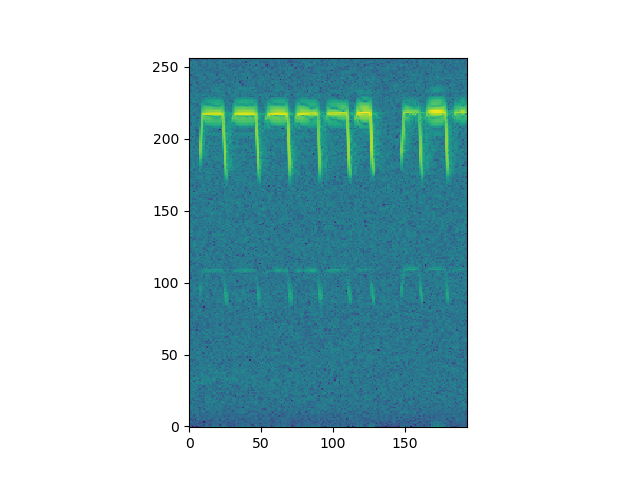

In [29]:
plt.figure()
plt.imshow(test_specgms[0].reshape(test_specgms.shape[1],test_specgms.shape[2]), origin='lower')